<a href="https://colab.research.google.com/github/sovanmohan/SDP-V6/blob/main/sdpv6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/AI4Bharat/IndicTrans2.git

Cloning into 'IndicTrans2'...
remote: Enumerating objects: 762, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 762 (delta 150), reused 103 (delta 103), pack-reused 585 (from 3)
Receiving objects: 100% (762/762), 4.15 MiB | 11.42 MiB/s, done.
Resolving deltas: 100% (492/492), done.


In [ ]:
!unzip OdiEnCorp_2.0.zip

Archive:  OdiEnCorp_2.0.zip
  inflating: OdiEnCorp_2.0/odiencorp20-dev  
  inflating: OdiEnCorp_2.0/odiencorp20-test  
  inflating: OdiEnCorp_2.0/odiencorp20-train  
  inflating: OdiEnCorp_2.0/README.txt  


In [ ]:
%cd /content/IndicTrans2/huggingface_interface

/content/IndicTrans2/huggingface_interface


In [ ]:
!python3 -m pip install nltk sacremoses pandas regex mock transformers>=4.33.2 mosestokenizer
!python3 -c "import nltk; nltk.download('punkt')"
!python3 -m pip install bitsandbytes scipy accelerate datasets
!python3 -m pip install sentencepiece

!git clone https://github.com/VarunGumma/IndicTransToolkit.git
%cd IndicTransToolkit
!python3 -m pip install --editable ./
%cd ..

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━

In [ ]:
import torch
from transformers import AutoModelForSeq2SeqLM, BitsAndBytesConfig, AutoTokenizer
from IndicTransToolkit import IndicProcessor

BATCH_SIZE = 4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
quantization = None

In [ ]:
def initialize_model_and_tokenizer(ckpt_dir, quantization):
    if quantization == "4-bit":
        qconfig = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.bfloat16,
        )
    elif quantization == "8-bit":
        qconfig = BitsAndBytesConfig(
            load_in_8bit=True,
            bnb_8bit_use_double_quant=True,
            bnb_8bit_compute_dtype=torch.bfloat16,
        )
    else:
        qconfig = None

    tokenizer = AutoTokenizer.from_pretrained(ckpt_dir, trust_remote_code=True)
    model = AutoModelForSeq2SeqLM.from_pretrained(
        ckpt_dir,
        trust_remote_code=True,
        low_cpu_mem_usage=True,
        quantization_config=qconfig,
    )

    if qconfig == None:
        model = model.to(DEVICE)
        if DEVICE == "cuda":
            model.half()

    model.eval()

    return tokenizer, model


def batch_translate(input_sentences, src_lang, tgt_lang, model, tokenizer, ip):
    translations = []
    for i in range(0, len(input_sentences), BATCH_SIZE):
        batch = input_sentences[i : i + BATCH_SIZE]

        # Preprocess the batch and extract entity mappings
        batch = ip.preprocess_batch(batch, src_lang=src_lang, tgt_lang=tgt_lang)

        # Tokenize the batch and generate input encodings
        inputs = tokenizer(
            batch,
            truncation=True,
            padding="longest",
            return_tensors="pt",
            return_attention_mask=True,
        ).to(DEVICE)

        # Generate translations using the model
        with torch.no_grad():
            generated_tokens = model.generate(
                **inputs,
                use_cache=True,
                min_length=0,
                max_length=256,
                num_beams=5,
                num_return_sequences=1,
            )

        # Decode the generated tokens into text

        with tokenizer.as_target_tokenizer():
            generated_tokens = tokenizer.batch_decode(
                generated_tokens.detach().cpu().tolist(),
                skip_special_tokens=True,
                clean_up_tokenization_spaces=True,
            )

        # Postprocess the translations, including entity replacement
        translations += ip.postprocess_batch(generated_tokens, lang=tgt_lang)

        del inputs
        torch.cuda.empty_cache()

    return translations

In [ ]:
en_indic_ckpt_dir = "ai4bharat/indictrans2-indic-en-1B"  # ai4bharat/indictrans2-en-indic-dist-200M
en_indic_tokenizer, en_indic_model = initialize_model_and_tokenizer(en_indic_ckpt_dir, quantization)

ip = IndicProcessor(inference=True)

en_sents = [
    "ଯେତେବେଳେ ମୁଁ ଛୋଟ ଥିଲି, ମୁଁ ପ୍ରତିଦିନ ପାର୍କକୁ ଯାଉଥିଲି |",
    "ସେଠି ତାଙ୍କର ଅନେକ ପୁରୁଣା ପୁସ୍ତକ ଅଛି, ଯାହା ସେ ତାଙ୍କର ପୂର୍ବଜଙ୍କୁଠାରୁ ବଂଶପାରମ୍ପର୍ଯ୍ୟରେ ପାଇଛନ୍ତି |",
    "ମୁଁ ବୁଝିପାରୁନାହିଁ ଯେ ମୋର ସମସ୍ୟା କିପରି ସମାଧାନ କରିବି |",
    "ସେ ବହୁତ ପରିଶ୍ରମୀ ଏବଂ ବୁଦ୍ଧିମାନ, ଯାହା ଫଳରେ ସେ ସମସ୍ତ ଭଲ ମାର୍କ୍ସ ପାଇଛି |",
    "ଗତ ସପ୍ତାହେ ଆମେ ଏକ ନୂଆ ଚଳଚ୍ଚିତ୍ର ଦେଖିଲୁ, ଯାହା ବହୁତ ପ୍ରେରଣାଦାୟକ ଥିଲା |",
    "ଯଦି ସେ ସମୟରେ ତୁମେ ମୋ ସହିତ ମିଶିଥାନ୍ତେ, ଆମେ ବାହାରେ ଖାଇବାକୁ ଯାଇଥାନ୍ତୁ |",
    "ସେ ତାଙ୍କ ଭଉଣୀ ସହିତ ଏକ ନୂଆ ସାଢ଼ି କିଣିବାକୁ ବଜାରକୁ ଗଲେ |",
    "ରାଜ୍ ମୋତେ କହିଲେ ଯେ ସେ ଆଗାମୀ ମାସରେ ତାଙ୍କ ଠାକୁରମାଙ୍କ ଘରକୁ ଯିବେ |",
    "ସମସ୍ତ ଛୋଟ ପିଲାମାନେ ପାର୍ଟିରେ ମଜା କରୁଥିଲେ ଏବଂ ବହୁତ ସାରା ମିଠା ଖାଉଥିଲେ |",
    "ମୋର ବନ୍ଧୁ ମୋତେ ତାଙ୍କ ଜନ୍ମଦିନ ପାର୍ଟିରେ ଆମନ୍ତ୍ରଣ କରିଛନ୍ତି, ଏବଂ ମୁଁ ତାଙ୍କୁ ଏକ ଉପହାର ଦେବି |",
]

src_lang, tgt_lang = "ory_Orya", "eng_Latn"
hi_translations = batch_translate(en_sents, src_lang, tgt_lang, en_indic_model, en_indic_tokenizer, ip)

print(f"\n{src_lang} - {tgt_lang}")
for input_sentence, translation in zip(en_sents, hi_translations):
    print(f"{src_lang}: {input_sentence}")
    print(f"{tgt_lang}: {translation}")

# flush the models to free the GPU memory
del en_indic_tokenizer, en_indic_model


ory_Orya - eng_Latn
ory_Orya: ଯେତେବେଳେ ମୁଁ ଛୋଟ ଥିଲି, ମୁଁ ପ୍ରତିଦିନ ପାର୍କକୁ ଯାଉଥିଲି |
eng_Latn: When I was a kid, I used to go to the park every day.
ory_Orya: ସେଠି ତାଙ୍କର ଅନେକ ପୁରୁଣା ପୁସ୍ତକ ଅଛି, ଯାହା ସେ ତାଙ୍କର ପୂର୍ବଜଙ୍କୁଠାରୁ ବଂଶପାରମ୍ପର୍ଯ୍ୟରେ ପାଇଛନ୍ତି |
eng_Latn: He has many old books there, which he has inherited from his ancestors.
ory_Orya: ମୁଁ ବୁଝିପାରୁନାହିଁ ଯେ ମୋର ସମସ୍ୟା କିପରି ସମାଧାନ କରିବି |
eng_Latn: I don't understand how to solve my problem.
ory_Orya: ସେ ବହୁତ ପରିଶ୍ରମୀ ଏବଂ ବୁଦ୍ଧିମାନ, ଯାହା ଫଳରେ ସେ ସମସ୍ତ ଭଲ ମାର୍କ୍ସ ପାଇଛି |
eng_Latn: He is very hardworking and intelligent, which has resulted in him getting all the good marks.
ory_Orya: ଗତ ସପ୍ତାହେ ଆମେ ଏକ ନୂଆ ଚଳଚ୍ଚିତ୍ର ଦେଖିଲୁ, ଯାହା ବହୁତ ପ୍ରେରଣାଦାୟକ ଥିଲା |
eng_Latn: Last week we saw a new movie, which was very inspiring.
ory_Orya: ଯଦି ସେ ସମୟରେ ତୁମେ ମୋ ସହିତ ମିଶିଥାନ୍ତେ, ଆମେ ବାହାରେ ଖାଇବାକୁ ଯାଇଥାନ୍ତୁ |
eng_Latn: If you had joined me at that time, we would have gone out to eat.
ory_Orya: ସେ ତାଙ୍କ ଭଉଣୀ ସହିତ ଏକ ନୂଆ ସାଢ଼ି କିଣିବାକୁ ବଜାରକୁ ଗଲେ |


In [ ]:
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from IndicTransToolkit import IndicProcessor

# Check for GPU availability
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize the model and tokenizer
model_name = "ai4bharat/indictrans2-indic-en-1B"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name, trust_remote_code=True).to(DEVICE)
ip = IndicProcessor(inference=True)

# List of Odia sentences
odia_sentences = [
    "ଯେତେବେଳେ ମୁଁ ଛୋଟ ଥିଲି, ମୁଁ ପ୍ରତିଦିନ ପାର୍କକୁ ଯାଉଥିଲି |",
    "ସେଠି ତାଙ୍କର ଅନେକ ପୁରୁଣା ପୁସ୍ତକ ଅଛି, ଯାହା ସେ ତାଙ୍କର ପୂର୍ବଜଙ୍କୁଠାରୁ ବଂଶପାରମ୍ପର୍ଯ୍ୟରେ ପାଇଛନ୍ତି |",
    # Add more sentences as needed
]

# Preprocess the sentences
src_lang = "ory_Orya"
tgt_lang = "eng_Latn"
batch = ip.preprocess_batch(odia_sentences, src_lang=src_lang, tgt_lang=tgt_lang)

# Tokenize and generate translations
inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to(DEVICE)
outputs = model.generate(**inputs)
translations = tokenizer.batch_decode(outputs, skip_special_tokens=True)

# Postprocess the translations
translated_sentences = ip.postprocess_batch(translations, lang=tgt_lang)

# Save the translations to the hypothesis file
with open("hypothesis.txt", "w", encoding="utf-8") as hyp_file:
    for sentence in translated_sentences:
        hyp_file.write(sentence + "\n")


In [ ]:
!wget https://raw.githubusercontent.com/AI4Bharat/IndicTrans2/main/compute_metrics.sh

--2025-04-05 04:36:53--  https://raw.githubusercontent.com/AI4Bharat/IndicTrans2/main/compute_metrics.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1333 (1.3K) [text/plain]
Saving to: ‘compute_metrics.sh’

compute_metrics.sh  100%[===================>]   1.30K  --.-KB/s    in 0s      

2025-04-05 04:36:53 (53.3 MB/s) - ‘compute_metrics.sh’ saved [1333/1333]



In [ ]:
!chmod +x compute_metrics.sh

In [ ]:
!./compute_metrics.sh hypothesis.txt reference.txt eng_Latn


Sat Apr 5 04:37:55 AM UTC 2025
[
{
 "name": "BLEU",
 "score": 1.2,
 "signature": "nrefs:1|case:mixed|eff:no|tok:13a|smooth:exp|version:2.5.1",
 "verbose_score": "7.3/1.3/0.7/0.4 (BP = 1.000 ratio = 1.464 hyp_len = 41 ref_len = 28)",
 "nrefs": "1",
 "case": "mixed",
 "eff": "no",
 "tok": "13a",
 "smooth": "exp",
 "version": "2.5.1"
},
{
 "name": "chrF2",
 "score": 5.2,
 "signature": "nrefs:1|case:mixed|eff:yes|nc:6|nw:0|space:no|version:2.5.1",
 "nrefs": "1",
 "case": "mixed",
 "eff": "yes",
 "nc": "6",
 "nw": "0",
 "space": "no",
 "version": "2.5.1"
}
]
{
 "name": "chrF2++",
 "score": 4.4,
 "signature": "nrefs:1|case:mixed|eff:yes|nc:6|nw:2|space:no|version:2.5.1",
 "nrefs": "1",
 "case": "mixed",
 "eff": "yes",
 "nc": "6",
 "nw": "2",
 "space": "no",
 "version": "2.5.1"
}


In [ ]:
import sacrebleu

# Load reference and hypothesis files
with open('reference.txt', 'r', encoding='utf-8') as ref_file:
    references = [line.strip() for line in ref_file]

with open('hypothesis.txt', 'r', encoding='utf-8') as hyp_file:
    hypotheses = [line.strip() for line in hyp_file]

# Compute BLEU score
bleu = sacrebleu.corpus_bleu(hypotheses, [references])
bleu_score = bleu.score

# Compute chrF++ score
chrf = sacrebleu.corpus_chrf(hypotheses, [references])
chrf_score = chrf.score

print(f"BLEU Score: {bleu_score}")
print(f"chrF++ Score: {chrf_score}")


BLEU Score: 1.226607913268064
chrF++ Score: 5.190576120316429


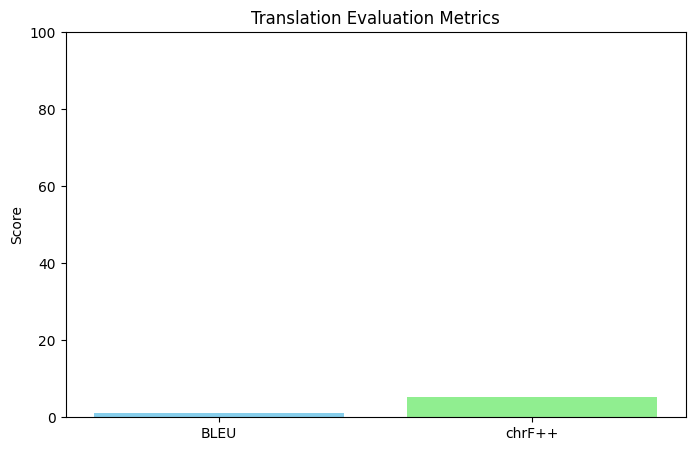

In [ ]:
import matplotlib.pyplot as plt

# Scores
scores = [bleu_score, chrf_score]
metrics = ['BLEU', 'chrF++']

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(metrics, scores, color=['skyblue', 'lightgreen'])
plt.ylim(0, 100)
plt.ylabel('Score')
plt.title('Translation Evaluation Metrics')
plt.show()


In [ ]:
!unzip train.zip

Archive:  train.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of train.zip or
        train.zip.zip, and cannot find train.zip.ZIP, period.


In [ ]:
!unzip train.zip

Archive:  train.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of train.zip or
        train.zip.zip, and cannot find train.zip.ZIP, period.


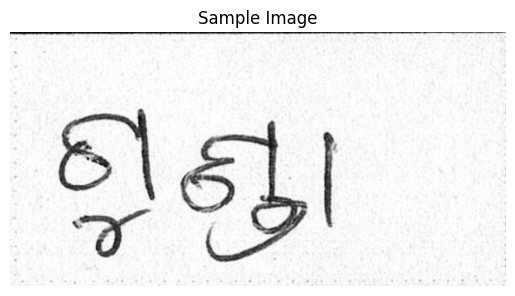

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Replace 'sample_image.png' with an actual image filename from your dataset
img = cv2.imread('/content/1.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.title('Sample Image')
plt.axis('off')
plt.show()


In [3]:
import zipfile
with zipfile.ZipFile('Odia_Train.zip', 'r') as file:
    file.extractall()

BadZipFile: File is not a zip file